statistical arbritrage
Uses linear regression to compute hedge ratio.

Z-score of spread used for mean-reversion entry/exit logic.

Total PnL: 12.94
Average Daily Return: 0.0177
Volatility: 0.4450
Sharpe Ratio: 0.63
Max Drawdown: 7.64


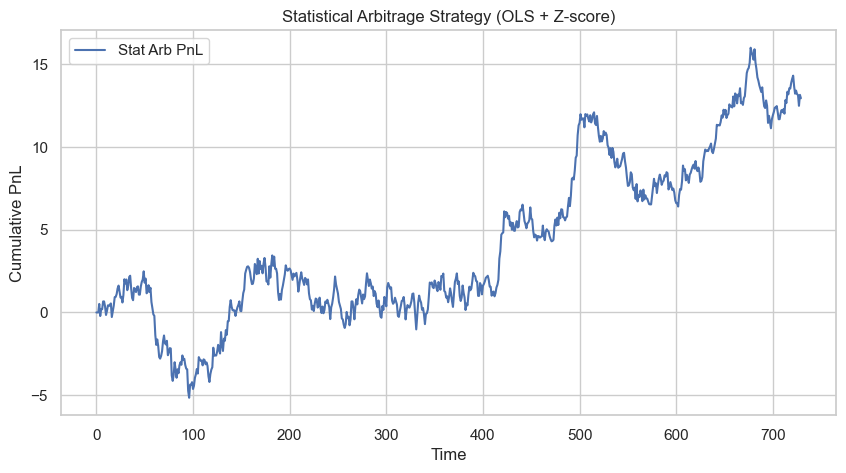

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
prices = np.loadtxt('prices.txt')
prices = prices.T

p1 = prices[0]
p2 = prices[1]

# Step 1: OLS hedge ratio
def compute_hedge_ratio(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    return beta

# Step 2: Spread and z-score
def compute_spread_zscore(p1, p2, window=20):
    beta = compute_hedge_ratio(p1, p2)
    spread = p2 - beta * p1
    spread_series = pd.Series(spread)
    rolling_mean = spread_series.rolling(window).mean()
    rolling_std = spread_series.rolling(window).std()
    z = (spread_series - rolling_mean) / rolling_std
    df = pd.DataFrame({'spread': spread_series, 'z': z})
    df = df.dropna().reset_index(drop=True)
    return df['spread'], df['z'], beta

# Step 3: Signal generation
def generate_signals(z, entry=1.0, exit=0.0):
    signals = np.zeros(len(z))
    for t in range(1, len(z)):
        if z.iloc[t-1] > entry:
            signals[t] = -1  # Short spread
        elif z.iloc[t-1] < -entry:
            signals[t] = 1   # Long spread
        elif abs(z.iloc[t-1]) < exit:
            signals[t] = 0   # Exit
        else:
            signals[t] = signals[t-1]
    return signals

# Step 4: PnL computation
def compute_pnl(signals, spread):
    spread = spread.reset_index(drop=True)
    spread_diff = np.diff(spread)
    signals = signals[:len(spread_diff)+1]  # Ensure proper alignment
    positions = signals[:-1]
    pnl = positions * spread_diff
    cumulative_pnl = np.cumsum(pnl)
    return pnl, cumulative_pnl

# Run
spread, zscore, beta = compute_spread_zscore(p1, p2)
signals = generate_signals(zscore)
pnl, cumulative_pnl = compute_pnl(signals, spread)

# Metrics
avg_return = np.mean(pnl)
volatility = np.std(pnl)
sharpe = avg_return / volatility * np.sqrt(252) if volatility > 0 else 0
max_dd = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

# Output
print(f"Total PnL: {cumulative_pnl[-1]:.2f}")
print(f"Average Daily Return: {avg_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_pnl, label='Stat Arb PnL')
plt.title("Statistical Arbitrage Strategy (OLS + Z-score)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.legend()
plt.show()

kalman filter cointegration
Dynamically estimates hedge ratio over time using Kalman filter.

Spread is calculated with time-varying beta; signals generated via z-score.

c:\Users\tavis\.vscode\algothon2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tavis\.vscode\algothon2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tavis\.vscode\algothon2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tavis\.vscode\algothon2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 

Total PnL: -2.03
Sharpe Ratio: -0.42
Max Drawdown: 5.36
              precision    recall  f1-score   support

           0       0.46      0.05      0.10       111
           1       0.49      0.94      0.65       109

    accuracy                           0.49       220
   macro avg       0.48      0.49      0.37       220
weighted avg       0.48      0.49      0.37       220



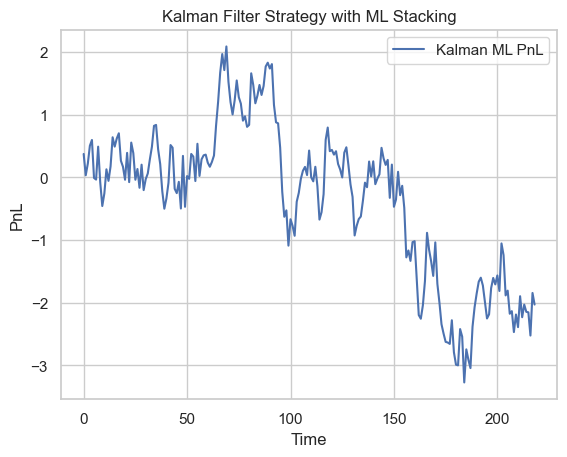

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from pykalman import KalmanFilter

# Load data
prices = np.loadtxt('prices.txt')
prices = prices.T  # shape: (assets, time)

# Select a pair (you can loop this for multiple pairs)
p1, p2 = prices[0], prices[1]

# Estimate dynamic hedge ratio using Kalman Filter
def kalman_beta(p1, p2):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  # state transition covariance
    obs_mat = np.vstack([p1, np.ones(len(p1))]).T[:, np.newaxis]

    kf = KalmanFilter(transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      initial_state_mean=np.zeros(2),
                      initial_state_covariance=np.ones((2, 2)),
                      observation_covariance=1.0,
                      transition_covariance=trans_cov)
    state_means, _ = kf.filter(p2)
    return state_means

betas = kalman_beta(p1, p2)
spread = p2 - (betas[:, 0] * p1 + betas[:, 1])
spread_series = pd.Series(spread).dropna()

# Feature engineering
window = 20
features = pd.DataFrame({
    'zscore': (spread_series - spread_series.rolling(window).mean()) / spread_series.rolling(window).std(),
    'momentum': spread_series.diff(),
    'volatility': spread_series.rolling(window).std(),
    'regime': (spread_series.rolling(window).std() > spread_series.rolling(window).std().median()).astype(int)
}).dropna()

# Label using forward return
future_returns = spread_series.shift(-1) - spread_series
features['label'] = np.sign(future_returns).map({-1: 0, 1: 1}).fillna(0).astype(int)
features = features.dropna()

# Split data
X = features.drop('label', axis=1)
y = features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build stacked ML model
base_models = [
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=3))
]
meta_model = LogisticRegression()
stacked = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacked.fit(X_train_scaled, y_train)

# Predict and backtest
preds = stacked.predict(X_test_scaled)
positions = np.where(preds == 1, 1, -1)
spread_diff = spread_series.iloc[-len(positions):].diff().dropna().values
pnl = positions[:-1] * spread_diff
cumulative_pnl = np.cumsum(pnl)

# Performance
sharpe = pnl.mean() / pnl.std() * np.sqrt(252) if pnl.std() > 0 else 0
max_dd = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

print(f"Total PnL: {cumulative_pnl[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}")
print(classification_report(y_test[:len(preds)], preds))

# Plot
plt.plot(cumulative_pnl, label="Kalman ML PnL")
plt.title("Kalman Filter Strategy with ML Stacking")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.legend()
plt.show()

PCA decomposition spread trading
First principal component used to define synthetic spread.

Trading signals are generated based on mean-reverting behavior of spread.

Also applied in a rolling window fashion.

Total PnL: -3.65
Average Daily Return: -0.0053
Volatility: 0.2593
Sharpe Ratio: -0.32
Max Drawdown: 10.94


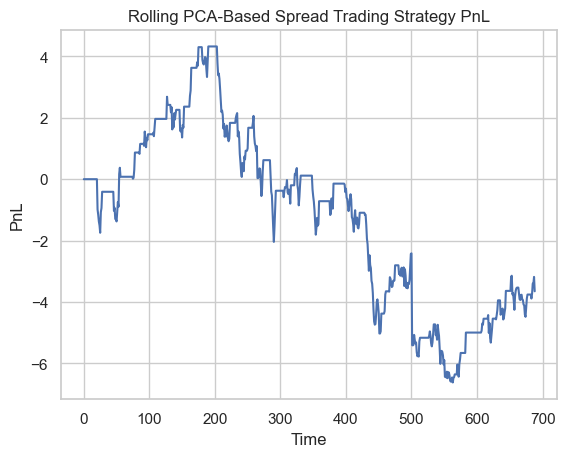

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load price data
prices = np.loadtxt("prices.txt", dtype=float).T
asset1, asset2 = prices[0], prices[1]

# Parameters
window = 60
entry_threshold = 1.5
exit_threshold = 0.5

spread_list = []

# Rolling PCA on 2-asset window
for i in range(window, len(asset1)):
    X_window = np.vstack([asset1[i - window:i], asset2[i - window:i]]).T
    pca = PCA(n_components=1)
    pca.fit(X_window)
    spread = pca.transform([[asset1[i], asset2[i]]])[0, 0]
    spread_list.append(spread)

spread_series = pd.Series(spread_list)
spread_mean = spread_series.rolling(20).mean()
spread_std = spread_series.rolling(20).std()
zscore = (spread_series - spread_mean) / spread_std

positions = np.zeros(len(zscore))
in_trade = False

for i in range(1, len(zscore)):
    if not in_trade:
        if zscore[i] > entry_threshold:
            positions[i] = -1
            in_trade = True
        elif zscore[i] < -entry_threshold:
            positions[i] = 1
            in_trade = True
    else:
        if abs(zscore[i]) < exit_threshold:
            positions[i] = 0
            in_trade = False
        else:
            positions[i] = positions[i - 1]

# Calculate PnL
spread_returns = np.diff(spread_list)
positions = positions[:-1]  # align
pnl = positions * spread_returns
cumulative_pnl = np.cumsum(pnl)

# Performance Metrics
avg_daily_return = pnl.mean()
volatility = pnl.std()
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
max_drawdown = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()
total_pnl = cumulative_pnl[-1]

# Output
print(f"Total PnL: {total_pnl:.2f}")
print(f"Average Daily Return: {avg_daily_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

# Plot
plt.plot(cumulative_pnl)
plt.title("Rolling PCA-Based Spread Trading Strategy PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()


Multi-layer perceptron

In [6]:
# NOT CURRENTLY WORKING

"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Load price data
prices = np.loadtxt("prices.txt", dtype=float).T
asset1, asset2 = prices[0], prices[1]

# Parameters
window = 60
z_window = 20
entry_z = 1.5
exit_z = 0.5

spread_list = []
positions = []
spread_returns = []

# Rolling nonlinear spread estimation using neural network
for t in range(window, len(asset1) - 1):
    X = np.vstack([asset1[t - window:t], asset2[t - window:t]]).T
    y = asset2[t - window:t]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
    mlp.fit(X_scaled, y)

    current_scaled = scaler.transform([[asset1[t], asset2[t]]])
    predicted = mlp.predict(current_scaled)
    spread = asset2[t] - predicted[0]
    spread_list.append(spread)

    if len(spread_list) < z_window + 1:
        positions.append(0)
        spread_returns.append(0)
        continue

    zscore = (spread - np.mean(spread_list[-z_window:])) / np.std(spread_list[-z_window:])
    if zscore > entry_z:
        positions.append(-1)
    elif zscore < -entry_z:
        positions.append(1)
    elif abs(zscore) < exit_z:
        positions.append(0)
    else:
        positions.append(positions[-1])

    ret = (asset2[t + 1] - asset2[t]) - (asset1[t + 1] - asset1[t])
    spread_returns.append(ret * positions[-1])

# Performance metrics
cumulative_pnl = np.cumsum(spread_returns)
avg_daily_return = np.mean(spread_returns)
volatility = np.std(spread_returns)
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
max_drawdown = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

# Plot
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(cumulative_pnl, label='Cumulative PnL')
plt.title("Nonlinear Spread Trading Strategy (MLP Regression)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()
plt.tight_layout()
plt.show()

# Output metrics
print(f"Total PnL: {cumulative_pnl[-1]:.2f}")
print(f"Average Daily Return: {avg_daily_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
"""

'\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.neural_network import MLPRegressor\n\n# Load price data\nprices = np.loadtxt("prices.txt", dtype=float).T\nasset1, asset2 = prices[0], prices[1]\n\n# Parameters\nwindow = 60\nz_window = 20\nentry_z = 1.5\nexit_z = 0.5\n\nspread_list = []\npositions = []\nspread_returns = []\n\n# Rolling nonlinear spread estimation using neural network\nfor t in range(window, len(asset1) - 1):\n    X = np.vstack([asset1[t - window:t], asset2[t - window:t]]).T\n    y = asset2[t - window:t]\n\n    scaler = StandardScaler()\n    X_scaled = scaler.fit_transform(X)\n\n    mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)\n    mlp.fit(X_scaled, y)\n\n    current_scaled = scaler.transform([[asset1[t], asset2[t]]])\n    predicted = mlp.predict(current_scaled)\n    spread = asset2[t] - predicted[0]\n    spread_list.append(spread)\n\n    if len(sprea

Random forest regression

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        17
           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        50

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



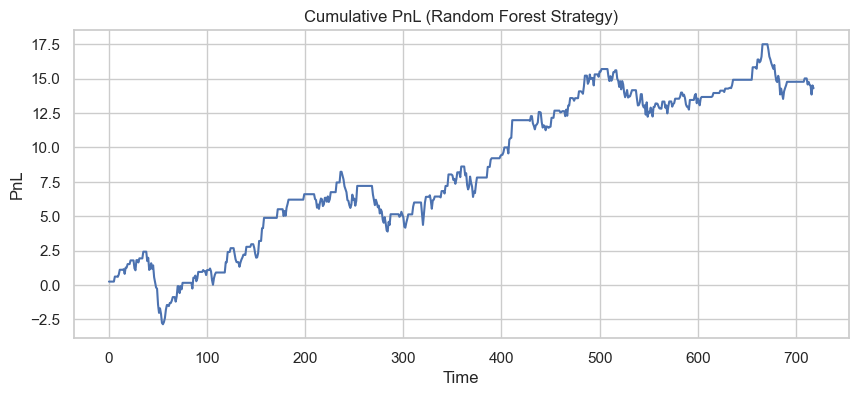

Total PnL: 14.30
Average Daily Return: 0.0196
Volatility: 0.3135
Sharpe Ratio: 0.99
Max Drawdown: 5.27


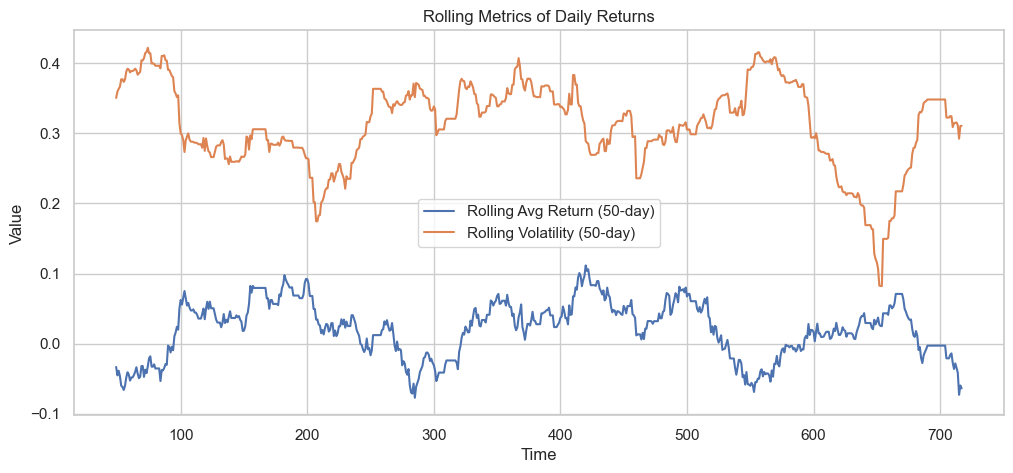

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load and transpose the price data
prices = np.loadtxt("prices.txt", dtype=float).T  # shape: (num_assets, time)

# Choose a pair of assets (example: asset 0 and asset 1)
asset1 = prices[0]
asset2 = prices[1]

# Step 1: Compute spread and z-score
def compute_spread_zscore(p1, p2, window=30):
    beta = np.polyfit(p1, p2, 1)[0]  # Linear regression for hedge ratio
    spread = p2 - beta * p1
    spread_series = pd.Series(spread)
    z = (spread_series - spread_series.rolling(window).mean()) / spread_series.rolling(window).std()
    return spread_series, z, beta

spread, zscore, beta = compute_spread_zscore(asset1, asset2)

# Step 2: Feature Engineering
df = pd.DataFrame({
    'spread': spread,
    'zscore': zscore,
    'spread_diff': spread.diff(),
    'zscore_diff': zscore.diff(),
})

# Step 3: Create target labels
df['label'] = 0
df.loc[df['zscore'] > 1, 'label'] = -1  # short
df.loc[df['zscore'] < -1, 'label'] = 1   # long
df.dropna(inplace=True)

# Step 4: Define features (X) and target (y)
X = df[['spread', 'zscore', 'spread_diff', 'zscore_diff']]
y = df['label']

# Step 5: Train/Test split (time-aware)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 6: Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Step 7: Evaluation
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 8: Predict full position series and calculate PnL
predicted_positions = rf.predict(X)[:-1]  # drop last to align with diff
spread_changes = df['spread'].diff().shift(-1).dropna()
pnl = predicted_positions[:len(spread_changes)] * spread_changes.values
cumulative_pnl = np.cumsum(pnl)

# Step 9: Plot cumulative PnL
plt.figure(figsize=(10, 4))
plt.plot(cumulative_pnl)
plt.title("Cumulative PnL (Random Forest Strategy)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

# Step 10: Analyze performance metrics
def analyze_pnl(pnl):
    returns = np.diff(pnl)
    avg_daily_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility != 0 else 0
    max_drawdown = np.max(np.maximum.accumulate(pnl) - pnl)

    print(f"Total PnL: {pnl[-1]:.2f}")
    print(f"Average Daily Return: {avg_daily_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    return returns

daily_returns = analyze_pnl(cumulative_pnl)

# Step 11: Rolling Metrics
rolling_window = 50
rolling_avg_return = pd.Series(daily_returns).rolling(rolling_window).mean()
rolling_volatility = pd.Series(daily_returns).rolling(rolling_window).std()

plt.figure(figsize=(12, 5))
plt.plot(rolling_avg_return, label="Rolling Avg Return (50-day)")
plt.plot(rolling_volatility, label="Rolling Volatility (50-day)")
plt.title("Rolling Metrics of Daily Returns")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Logistic regression

              precision    recall  f1-score   support

          -1       1.00      0.72      0.84        18
           0       0.93      0.91      0.92        77
           1       0.88      1.00      0.93        50

    accuracy                           0.92       145
   macro avg       0.94      0.88      0.90       145
weighted avg       0.92      0.92      0.92       145



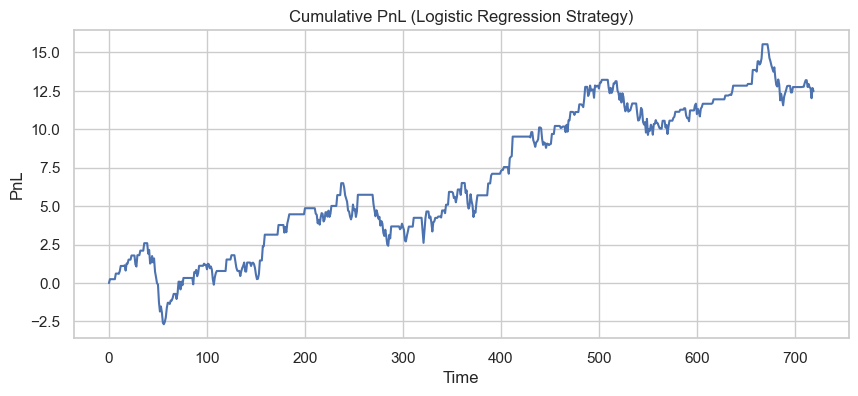

Total PnL: 12.48
Average Daily Return: 0.0174
Volatility: 0.3132
Sharpe Ratio: 0.88
Max Drawdown: 5.27


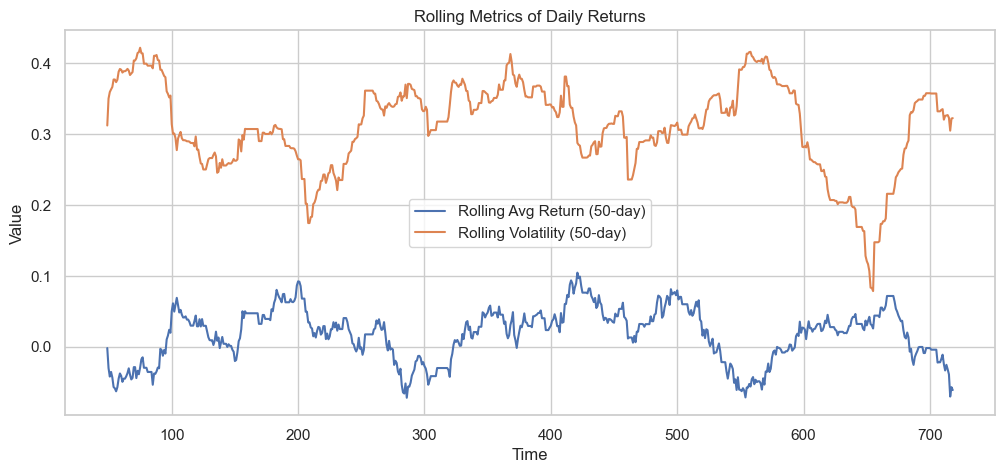

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load and transpose the price data
prices = np.loadtxt("prices.txt", dtype=float).T

# Select a pair of assets (e.g., first two)
asset1 = prices[0]
asset2 = prices[1]

# Function to compute spread and z-score
def compute_spread_zscore(p1, p2, window=30):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    spread_series = pd.Series(spread)
    z = (spread_series - spread_series.rolling(window).mean()) / spread_series.rolling(window).std()
    return spread_series, z, beta

spread, zscore, beta = compute_spread_zscore(asset1, asset2)

# Function to compute RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Add technical indicators
def add_indicators(df):
    df['momentum'] = df['spread'].diff(3)
    df['volatility'] = df['spread'].rolling(window=10).std()
    df['rsi'] = compute_rsi(df['spread'], window=14)
    df['bb_upper'] = df['spread'].rolling(20).mean() + 2 * df['spread'].rolling(20).std()
    df['bb_lower'] = df['spread'].rolling(20).mean() - 2 * df['spread'].rolling(20).std()
    df['bb_width'] = df['bb_upper'] - df['bb_lower']
    df.dropna(inplace=True)
    return df

# Construct DataFrame with labels
df = pd.DataFrame({'spread': spread, 'zscore': zscore})
df['label'] = 0
df.loc[df['zscore'] > 1, 'label'] = -1  # short
df.loc[df['zscore'] < -1, 'label'] = 1  # long
df = add_indicators(df)

# Define features and target
X = df[['spread', 'zscore', 'momentum', 'volatility', 'rsi', 'bb_width']]
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Evaluation
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

# Full prediction and trading simulation
positions = lr.predict(X)[:-1]
spread_changes = df['spread'].diff().shift(-1).dropna()
pnl = positions[:len(spread_changes)] * spread_changes.values
cumulative_pnl = np.cumsum(pnl)

# Plot cumulative PnL
plt.figure(figsize=(10, 4))
plt.plot(cumulative_pnl)
plt.title("Cumulative PnL (Logistic Regression Strategy)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

# Analyze PnL performance
def analyze_pnl(pnl):
    returns = np.diff(pnl)
    avg_daily_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility != 0 else 0
    max_drawdown = np.max(np.maximum.accumulate(pnl) - pnl)

    print(f"Total PnL: {pnl[-1]:.2f}")
    print(f"Average Daily Return: {avg_daily_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    return returns

daily_returns = analyze_pnl(cumulative_pnl)

# Rolling performance metrics
rolling_window = 50
rolling_avg_return = pd.Series(daily_returns).rolling(rolling_window).mean()
rolling_volatility = pd.Series(daily_returns).rolling(rolling_window).std()

# Plot rolling metrics
plt.figure(figsize=(12, 5))
plt.plot(rolling_avg_return, label="Rolling Avg Return (50-day)")
plt.plot(rolling_volatility, label="Rolling Volatility (50-day)")
plt.title("Rolling Metrics of Daily Returns")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Volatility regime filter
Used to selectively allow trading during low or moderate volatility periods to avoid high-risk regimes.

Total PnL: 3.91
Average Daily Return: 0.0054
Volatility: 0.1041
Sharpe Ratio: 0.82
Max Drawdown: 1.53


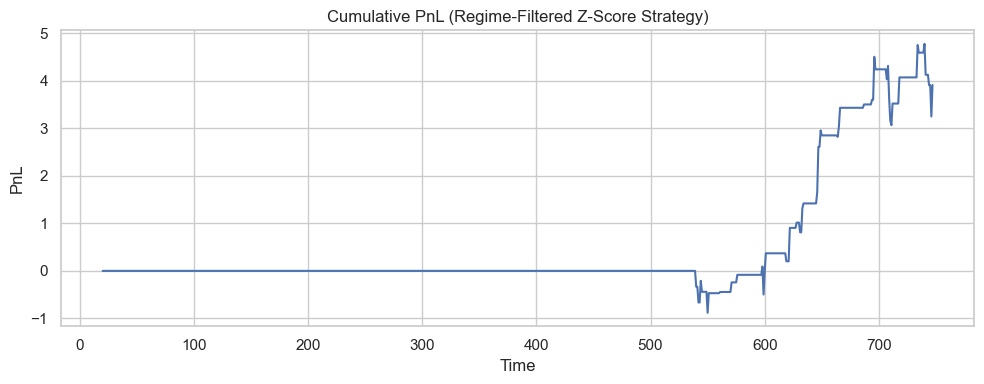

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller

# Load prices
prices = np.loadtxt("prices.txt", dtype=float).T
asset1, asset2 = prices[0], prices[1]

# Static hedge ratio using OLS
beta = np.polyfit(asset1, asset2, 1)[0]
spread = asset2 - beta * asset1
spread_series = pd.Series(spread)

# Rolling z-score
window = 20
spread_mean = spread_series.rolling(window).mean()
spread_std = spread_series.rolling(window).std()
zscore = (spread_series - spread_mean) / spread_std

# Create regime filter features
df = pd.DataFrame({
    'asset1': asset1,
    'asset2': asset2,
    'spread': spread,
    'zscore': zscore
})
df['return'] = df['spread'].diff().shift(-1)
df['volatility'] = df['spread'].rolling(10).std()
df['momentum'] = df['spread'].diff(5)
df['label'] = (df['return'] > 0).astype(int)

# Drop NaNs
df = df.dropna()

# Train/test split
split = int(len(df) * 0.7)
X_train = df[['zscore', 'volatility', 'momentum']].iloc[:split]
y_train = df['label'].iloc[:split]
X_test = df[['zscore', 'volatility', 'momentum']].iloc[split:]
y_test = df['label'].iloc[split:]

# Train regime filter
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
regime_pred = clf.predict(X_test)

# Strategy with regime filtering
z = df['zscore'].values
positions = np.zeros(len(z))
entry_threshold = 1.5
exit_threshold = 0.5

for i in range(split, len(z)):
    if regime_pred[i - split] == 1:  # Only trade if favorable regime
        if z[i] > entry_threshold:
            positions[i] = -1
        elif z[i] < -entry_threshold:
            positions[i] = 1
        elif abs(z[i]) < exit_threshold:
            positions[i] = 0
        else:
            positions[i] = positions[i - 1]
    else:
        positions[i] = 0

# Calculate PnL
spread_return = df['spread'].diff().shift(-1)
pnl = positions[:-1] * spread_return.iloc[1:]
cumulative_pnl = np.cumsum(pnl.dropna())

# Performance metrics
avg_daily_return = pnl.mean()
volatility = pnl.std()
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
max_drawdown = (np.maximum.accumulate(cumulative_pnl) - cumulative_pnl).max()

# Output metrics and plot
print(f"Total PnL: {cumulative_pnl.iloc[-1]:.2f}")
print(f"Average Daily Return: {avg_daily_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(cumulative_pnl)
plt.title("Cumulative PnL (Regime-Filtered Z-Score Strategy)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.tight_layout()
plt.show()